In [14]:
using DifferentialEquations
using JLD2
using LinearAlgebra
using Plots
using Roots
using Statistics

include("../model/Plant.jl")

Main.Plant

In [15]:
state = Plant.State()
u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]

7-element Vector{Float64}:
   0.8
   5.472e-46
   0.137
   0.389
   0.8
 -62.0
   0.0

In [16]:
# The function which must be minimized to find the equilibrium voltage.
function Ca_difference(p, v)
    IKCa = p.gI*Plant.h∞(v)*Plant.m∞(v)^3*(p.EI-v) + p.gK*Plant.n∞(v)^4*(p.EK-v) + p.gT*Plant.x∞(p, v)*(p.EI-v) + p.gₕ*(p.Eₕ-v)/((1+exp(10*(v-50)))*(1+exp(-(v-63)/7.8))^3) + p.gL*(p.EL-v)
    x_null_Ca = 0.5*IKCa/(p.gKCa*(v-p.EK) - IKCa)
    Ca_null_Ca = p.Kc*Plant.x∞(p, v)*(p.ECa-v+p.ΔCa)
    return x_null_Ca - Ca_null_Ca
end

Ca_difference (generic function with 1 method)

In [17]:
# Finds the equilibrium in the slow subsystem.
function Ca_x_eq(p, min_V=(p.EL+p.EK)/2)
    v_eq = find_zero(v -> Ca_difference(p, v), min_V)
    Ca_eq = p.Kc*Plant.x∞(p, v_eq)*(p.ECa-v_eq+p.ΔCa)
    x_eq = Plant.x∞(p, v_eq)
    return v_eq, Ca_eq, x_eq
end

Ca_x_eq (generic function with 2 methods)

In [18]:
function countSpikes(sol, p, debug=false)
    # Obtain burst reset times.
    resets = []
    Ca = 5
    x = 1
    v_eq::Float64 = 0.0
    Ca_eq::Float64 = 0.0
    x_eq::Float64 = 0.0
    try
        v_eq, Ca_eq, x_eq = Ca_x_eq(p, min(sol(sol.t, idxs=(6))...))
    catch e
        if debug
            print("No equilibrium found.")
        end
        return [0]
    end

    for i in 2:length(sol)
        x = 1
        Ca = 5
        if sol[i-1][x] < x_eq && sol[i][x] < x_eq && sol[i][Ca] <= Ca_eq < sol[i-1][Ca]
            push!(resets, i)
        end
    end

    if debug
        print("$(length(resets)) burst resets observed.")
    end

    V_threshold = 0.0

    # Obtain spike counts per burst.
    spike_counts = []
    for i in 1:length(resets)-1
        spike_count = 0
        for j in resets[i]:resets[i+1]
            if sol[j-1][6] < V_threshold < sol[j][6]
                spike_count += 1
            end
        end
        if spike_count > 0
            push!(spike_counts, spike_count)
        end
    end

    if spike_counts == []
        return [0]
    else
        return spike_counts
    end
end

countSpikes (generic function with 2 methods)

In [19]:
function transitionMap(spike_counts)
    plt = scatter(1, markeralpha=0.2, legend=false, aspect_ratio=:equal, size=(600, 600), xticks=0:maximum(spike_counts), yticks=0:maximum(spike_counts), xlims=(-0.5, maximum(spike_counts) + 0.5), ylims=(-0.5, maximum(spike_counts) + 0.5))
    plot!(plt, [0, maximum(spike_counts)], [0, maximum(spike_counts)], linealpha=0.2)
    for i in 1:length(spike_counts)-1
        push!(plt, (spike_counts[i], spike_counts[i+1]))
    end
    return plt
end

transitionMap (generic function with 1 method)

In [20]:
function markovChain(spike_counts)
    if length(spike_counts) == 0
        return zeros(0, 0)
    end
    size = max(spike_counts...)
    if size == 0
        return zeros(0, 0)
    end
    rows = []
    for i in 0:size
        row = zeros(size+1)
        for j in 1:length(spike_counts)-1
            if spike_counts[j] == i
                row[spike_counts[j+1]+1] += 1
            end
        end
        if sum(row) == 0
            push!(rows, row)
        else
            push!(rows, row/sum(row))
        end
    end
    return reduce(vcat, transpose.(rows))
end

markovChain (generic function with 1 method)

In [21]:
function structifyParams(p)
    return Plant.Params(
        Cₘ   = p[1],
        gI   = p[2],
        gK   = p[3],
        gₕ   = p[4],
        gL   = p[5],
        gT   = p[6],
        gKCa = p[7],
        EI   = p[8],
        EK   = p[9],
        Eₕ   = p[10],
        EL   = p[11],
        ECa  = p[12],
        Kc   = p[13],
        τₓ   = p[14],
        ρ    = p[15],
        Δx   = p[16],
        ΔCa  = p[17]
    )
end

structifyParams (generic function with 1 method)

In [22]:
function melibeNewHelper!(du, u, p, t)
    θ = structifyParams(p)
    Plant.melibeNew!(du, u, θ, t)
end

melibeNewHelper! (generic function with 1 method)

# Generating a spike count sweep
Specify overall sweep dimensions:
- ΔCa_min: Minimum calcium shift.
- ΔCa_max: Maximum calcium shift.
- ΔCa_resolution: Number of ΔCa values to sweep over.
- ΔCa_chunk_resolution: Number of ΔCa values to sweep over in each chunk.
- Δx_min: Minimum x shift.
- Δx_max: Maximum x shift.
- Δx_resolution: Number of Δx values to sweep over.
- Δx_chunk_resolution: Number of Δx values to sweep over in each chunk.

In [33]:
ΔCa_min = -50.0
ΔCa_max = 35.0
ΔCa_resolution = 40
Δx_min = -2.5
Δx_max = 0.0
Δx_resolution = Int(ΔCa_resolution/2)
chunk_proportion = 1/10

tspan = (0, 1e5)

(0, 100000.0)

In [43]:
for chunk in 1:Int(1/chunk_proportion)
    params = []
    chunk_ΔCa_min = ΔCa_min + (ΔCa_max - ΔCa_min)*chunk_proportion*(chunk-1)
    chunk_ΔCa_max = ΔCa_min + (ΔCa_max - ΔCa_min)*(chunk_proportion*chunk - 1/ΔCa_resolution)
    for ΔCa in range(chunk_ΔCa_min, chunk_ΔCa_max, length=Int(ΔCa_resolution*chunk_proportion))
        chunk_Δx_min = Δx_min + (Δx_max - Δx_min)*chunk_proportion*(chunk-1)
        chunk_Δx_max = Δx_min + (Δx_max - Δx_min)*(chunk_proportion*chunk - 1/Δx_resolution)
        for Δx in range(chunk_Δx_min, chunk_Δx_max, length=Int(Δx_resolution*chunk_proportion))
            θ = Plant.Params(
                ΔCa = ΔCa,
                Δx = Δx
            )
            p = [
                θ.Cₘ,
                θ.gI,
                θ.gK,
                θ.gₕ,
                θ.gL,
                θ.gT,
                θ.gKCa,
                θ.EI,
                θ.EK,
                θ.Eₕ,
                θ.EL,
                θ.ECa,
                θ.Kc,
                θ.τₓ,
                θ.ρ,
                θ.Δx,
                θ.ΔCa
            ]
            push!(params, p)
        end
        ranges = Dict(
            "ΔCa_min" => chunk_ΔCa_min,
            "ΔCa_max" => chunk_ΔCa_max,
            "Δx_min" => chunk_Δx_min,
            "Δx_max" => chunk_Δx_max
        )
        @save "output/chunk_$(chunk)_ranges.jld2" ranges
    end
    prob = ODEProblem(melibeNewHelper!, u0, tspan, params[1])
    prob_func(prob, i, repeat) = remake(prob, p=params[trunc(Int, i)]) # Why are we getting Floats here?
    function output_func(sol, i)
        spike_counts = countSpikes(sol, structifyParams(params[i]))
        if length(spike_counts) < 2
            return (-Inf, false)
        else
            return (log(var(spike_counts)+1), false)
        end
    end
    monteprob = EnsembleProblem(prob, output_func=output_func, prob_func=prob_func, safetycopy=false)
    sol = solve(monteprob, Tsit5(), reltol=1e-5, abstol=1e-5, EnsembleThreads(), trajectories=trunc(Int, ΔCa_resolution*Δx_resolution*chunk_proportion^2), verbose=false);
    @save "output/chunk_$(chunk).jld2" sol
    println("Finished chunk $chunk of $(Int(1/chunk_proportion)): $(round(100*chunk*chunk_proportion, digits=2))%")
end

Finished chunk 1 of 10: 10.0%
Finished chunk 2 of 10: 20.0%
Finished chunk 3 of 10: 30.0%
Finished chunk 4 of 10: 40.0%
Finished chunk 5 of 10: 50.0%
Finished chunk 6 of 10: 60.0%
Finished chunk 7 of 10: 70.0%
Finished chunk 8 of 10: 80.0%
Finished chunk 9 of 10: 90.0%
Finished chunk 10 of 10: 100.0%


In [35]:
ΔCa_length = 8
Δx_length = 4

range_ΔCa = range(-50, 35, length=ΔCa_length)
range_Δx = range(-2.5, 0, length=Δx_length)
params = []
for ΔCa in range_ΔCa
    for Δx in range_Δx
        θ = Plant.Params(
            ΔCa = ΔCa,
            Δx = Δx
        )
        p = [
            θ.Cₘ,
            θ.gI,
            θ.gK,
            θ.gₕ,
            θ.gL,
            θ.gT,
            θ.gKCa,
            θ.EI,
            θ.EK,
            θ.Eₕ,
            θ.EL,
            θ.ECa,
            θ.Kc,
            θ.τₓ,
            θ.ρ,
            θ.Δx,
            θ.ΔCa
        ]
        push!(params, p)
    end
end

tspan = (0, 3e5)

(0, 300000.0)

In [36]:
prob = ODEProblem(melibeNewHelper!, u0, tspan, params[1])
prob_func(prob, i, repeat) = remake(prob, p=params[trunc(Int, i)]) # Why are we getting Floats here?
function output_func(sol, i)
    spike_counts = countSpikes(sol, structifyParams(params[i]))
    if length(spike_counts) < 2
        return (-Inf, false)
    else
        return (log(var(spike_counts)+1), false)
    end
end
monteprob = EnsembleProblem(prob, output_func=output_func, prob_func=prob_func, safetycopy=false)
sol = solve(monteprob, Tsit5(), reltol=1e-5, abstol=1e-5, EnsembleThreads(), trajectories=ΔCa_length*Δx_length, verbose=false);

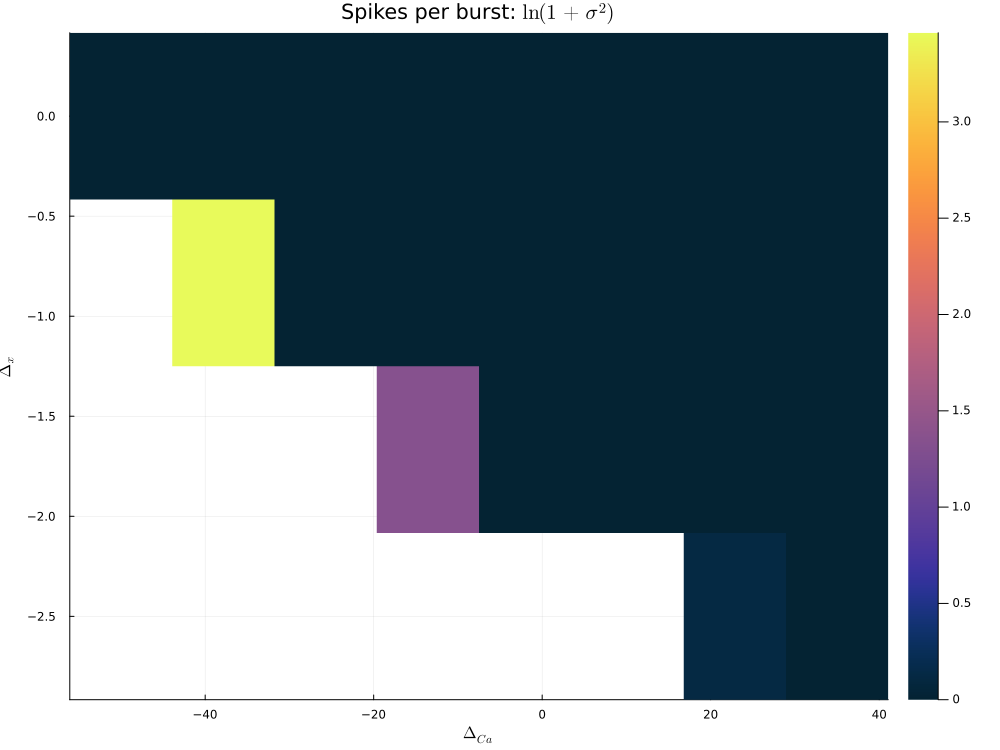

In [38]:
heatmap(range_ΔCa, range_Δx, reshape(sol, (Δx_length, ΔCa_length)), xlabel="\$Δ_{Ca}\$", ylabel="\$Δ_x\$", color=:thermal, title="Spikes per burst: \$\\ln(1+\\sigma^2)\$", size=(1000, 750), dpi=1000)

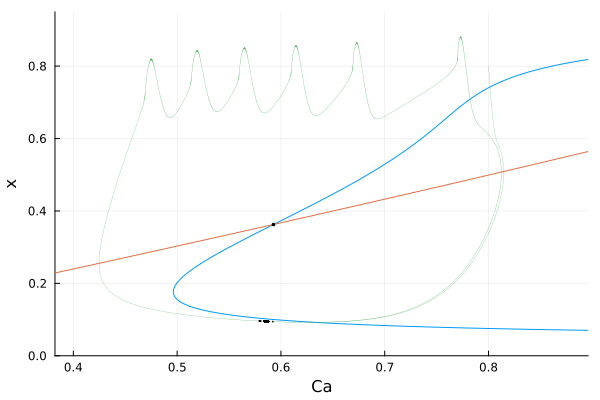

In [39]:
p = Plant.Params(
    ΔCa = range_ΔCa[5],
    Δx = range_Δx[4]
)

voltages = range(-70, 20, length=1000)

# Here we let y be at its equilibrium.
IKCa = [p.gI*Plant.h∞(v)*Plant.m∞(v)^3*(p.EI-v) + p.gK*Plant.n∞(v)^4*(p.EK-v) + p.gT*Plant.x∞(p, v)*(p.EI-v) + p.gₕ*(p.Eₕ-v)/((1+exp(10*(v-50)))*(1+exp(-(v-63)/7.8))^3) + p.gL*(p.EL-v) for v in voltages]

x_null_Cas = [0.5*IKCa[i]/(p.gKCa*(voltages[i]-p.EK) - IKCa[i]) for i in 1:length(voltages)]
x_null_xs = [Plant.x∞(p, v) for v in voltages]

# The paper says we should use these, but they don't really seem to work.
# IT = [p.gI*Plant.h∞(voltages[i])*Plant.m∞(voltages[i])^3*(p.EI-voltages[i]) + p.gK*Plant.n∞(voltages[i])^4*(p.EK-voltages[i]) - IKCa[i] + p.gₕ*(p.Eₕ-voltages[i])/((1+exp(10*(voltages[i]-50)))*(1+exp(-(voltages[i]-63)/7.8))^3) + p.gL*(p.EL-voltages[i]) for i in 1:length(voltages)]
# Ca_null_Cas = [IT[i]*(p.ECa - voltages[i] + p.ΔCa)/(p.EI-voltages[i]) for i in 1:length(voltages)]
Ca_null_Cas = [p.Kc*Plant.x∞(p, v)*(p.ECa-v+p.ΔCa) for v in voltages]
Ca_null_xs = [Plant.x∞(p, v) for v in voltages]


plt = plot(x_null_Cas, x_null_xs, xlabel="Ca", ylabel="x", xlim=(0.0, 1.5), ylim=(0.0, 0.95), legend=false)
plot!(plt, Ca_null_Cas, Ca_null_xs)

long_tspan = (0, 1e6)
prob = ODEProblem(Plant.melibeNew!, u0, long_tspan, p)
sol = solve(prob, Tsit5(), reltol=1e-5, abstol=1e-5)

v_eq, Ca_eq, x_eq = Ca_x_eq(p, min(sol(sol.t, idxs=(6))...))

burst_resets = []
for i in 2:length(sol)
    x = 1
    Ca = 5
    if sol[i-1][x] < x_eq && sol[i][x] < x_eq && sol[i][Ca] <= Ca_eq < sol[i-1][Ca]
        push!(burst_resets, i)
    end
end

plot!(plt, sol, idxs=(5, 1), lw=0.2)
scatter!(plt, [Ca_eq], [x_eq], ms=2, mc=:black)
scatter!(plt, [sol[i][5] for i in burst_resets], [sol[i][1] for i in burst_resets], ms=1.0, mc=:black)